In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

from matplotlib.backends.backend_pdf import PdfPages

In [3]:
# Load all k-mer data files
def load_kmer_data():
    # Get the current working directory (where the notebook is running)
    notebook_dir = os.getcwd()
    
    # Construct the path to the data directory relative to the notebook
    data_path = os.path.abspath(os.path.join(notebook_dir, "..", "..", "data", "enhancer_identification"))

    # Check if the data directory exists
    if not os.path.isdir(data_path):
        raise FileNotFoundError(f"Data directory not found: {data_path}")
    
    # Find all relevant files in the data directory
    files = glob.glob(os.path.join(data_path, "*-mer_identification_train.txt"))
    
    data = {}
    for file in files:
        kmer_type = os.path.basename(file).split("_")[0]  # Extract k-mer type (e.g., 3-mer, 4-mer)
        k = int(kmer_type.split("-")[0])  # Extract k value from k-mer type (e.g., 3 from 3-mer)
        
        if 3 <= k <= 6:  # Only include k-mers from 3 to 6
            df = pd.read_csv(file, sep='\t', header=None, names=['sequence', 'label'])
            data[k] = df
    return data

# Convert sequences to feature vectors using k-mer counts
def vectorize_sequences(data):
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 6))  # Adjust n-gram range if needed
    feature_vectors = {}
    for kmer_type, df in data.items():
        X = vectorizer.fit_transform(df['sequence'])
        y = df['label']
        feature_vectors[kmer_type] = (X, y)
    return feature_vectors

In [4]:
# Load data
data = load_kmer_data()

# Vectorize sequences
feature_vectors = vectorize_sequences(data)

In [5]:
def plot_umap_binary(X, y, ax, title):
    umap = UMAP(n_components=2, random_state=42)
    # umap = UMAP(n_neighbors=6, min_dist=0.7, random_state=42)

    X_embedded = umap.fit_transform(X.toarray())

    # Separate enhancers and non-enhancers by label
    enhancers = X_embedded[np.array(y) == 1]
    non_enhancers = X_embedded[np.array(y) == 0]

    # Plotting
    ax.scatter(enhancers[:, 0], enhancers[:, 1], label="Enhancer", alpha=0.5, color="red", marker="o")
    ax.scatter(non_enhancers[:, 0], non_enhancers[:, 1], label="Non-Enhancer", alpha=0.5, color="blue", marker="s")

    ax.set_title(title)
    ax.set_xlabel("UMAP Dimension 1")
    ax.set_ylabel("UMAP Dimension 2")
    ax.legend(loc="upper right")

/data/phattt/project/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/data/phattt/project/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/data/phattt/project/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/data/phattt/project/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


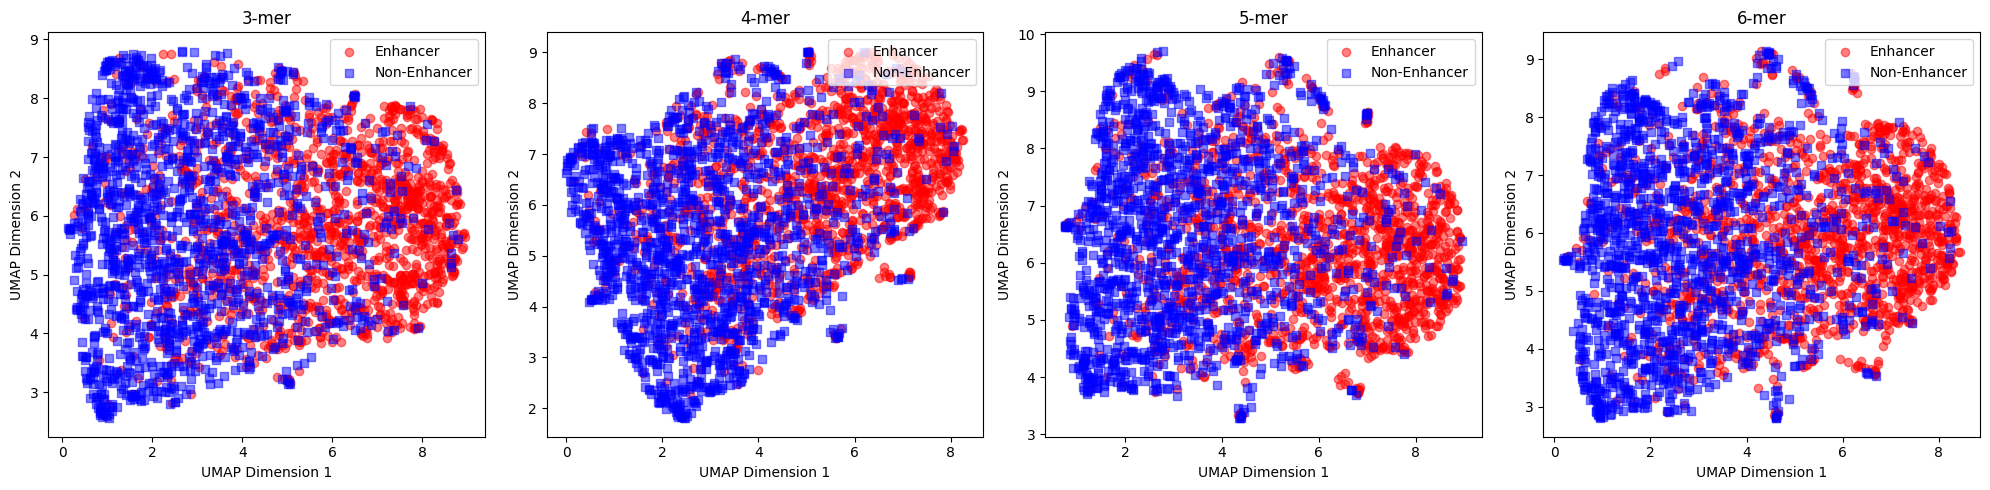

In [6]:
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.ravel()

# Loop through feature_vectors to create UMAP plots
for i, ax in zip(range(3, 7), axes):
    X, y = feature_vectors[i]
    plot_umap_binary(X, y, ax, f"{i}-mer")

plt.tight_layout()

# Save plot to PDF
with PdfPages('umap_visualizations.pdf') as pdf:
    pdf.savefig(fig)


plt.show()